In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import integrate, interpolate
from scipy import optimize
from torch.autograd import grad
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
from scipy.integrate import solve_ivp, odeint
from scipy.interpolate import interp1d

In [2]:
# no_GEM


In [3]:
class PINN_sys(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PINN_sys, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size), nn.Tanh(),
            nn.Linear(hidden_size, hidden_size), nn.Tanh(),
            nn.Linear(hidden_size, hidden_size), nn.Tanh(),
            nn.Linear(hidden_size, hidden_size), nn.Tanh(),
            nn.Linear(hidden_size, output_size), nn.Tanh()
        )
        self.params = nn.Parameter(torch.rand(3))  # Learnable parameters

    def forward(self, x):
        return self.net(x)

# Training function
def train_pinn_sys(model, 
                   t_train, 
                   G1_data,
                   G2_data,
                   P_data,
                   zero_init,
                   num_epochs, 
                   learning_rate
                   ):
    
    # Define the loss function (MSE for the PINN)
    criterion = nn.MSELoss()

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Define the learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=50, factor=0.5, verbose=True)
    
    # write the loss and params to a list
    epoch_list = []
    loss_list = []
    k1_list = []
    k2_list = []
    k3_list = []

    # Training loop
    for epoch in range(num_epochs):
        # Convert to PyTorch tensors
        t_train = torch.FloatTensor(t_train.reshape(-1, 1))
        G1_tensor = torch.FloatTensor(G1_data.reshape(-1, 1))
        G2_tensor = torch.FloatTensor(G2_data.reshape(-1, 1))
        P_tensor = torch.FloatTensor(P_data.reshape(-1, 1))
        zero_init = torch.FloatTensor(zero_init.reshape(-1, 1))
        
        t_train.requires_grad_()

        # Forward pass
        NN = model(t_train)
        G1, G2, P = torch.split(NN, 1, dim=1)
        
        G1_ones = torch.ones_like(G1)
        G2_ones = torch.ones_like(G2)
        P_ones = torch.ones_like(P)

        # Compute the gradients of the variables
        G1_t = grad(G1, t_train, G1_ones, create_graph=True)[0]
        G2_t = grad(G2, t_train, G2_ones, create_graph=True)[0]
        P_t = grad(P, t_train, P_ones, create_graph=True)[0]
        
        # ensure the model parameters are positive
        param_reg = torch.abs(model.params)
        k1 = param_reg[0]
        k2 = param_reg[1]
        k3 = param_reg[2]
        
        # residual loss
        l1 = criterion(G1_t, -k1*G1 + 2*k2*G2)
        l2 = criterion(G2_t, k1*G1 - k2*G2 - k3*G2)
        l3 = criterion(P_t, k3*G2)
        
        # data loss
        sum_loss1 = criterion(G1, G1_tensor)
        sum_loss2 = criterion(G2, G2_tensor)
        sum_loss3 = criterion(P, P_tensor)
        
        # initial conditions loss
        G1_init_loss = criterion(G1[0], zero_init[0])
        G2_init_loss = criterion(G2[0], zero_init[1])
        P_init_loss = criterion(P[0], zero_init[2])
        
       
        # residual loss + data loss + initial conditions loss 
        total_loss = (l1 + l2 + l3 + \
                      sum_loss1 + sum_loss2 + sum_loss3 + \
                      G1_init_loss + G2_init_loss + P_init_loss)       

        # Backward pass and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        # Update the learning rate based on the validation loss
        scheduler.step(total_loss)
        
        # Print progress
        if (epoch + 1) % 200 == 0:
            loss_item = round(total_loss.item(), 4)
            param_item = param_reg.data.numpy()
            epoch_list.append(epoch+1)
            loss_list.append(loss_item)
            k1_list.append(param_item[0])
            k2_list.append(param_item[1])
            k3_list.append(param_item[2])
            print(f'Epoch [{epoch+1}/{num_epochs}]', 
                  f'Loss: {total_loss.item():.2e}', 
                  f'params: {param_reg.data.numpy()}')
            
        # save list containing loss and params to csv files
        loss_param_df = pd.DataFrame(data={"Num Epoch": epoch_list,
                                           "loss": loss_list,
                                           "k1": k1_list,
                                           "k2": k2_list,
                                           "k3": k3_list
                                           })
        loss_param_df.to_csv("./loss_param_1f.csv", sep=',',index=False)

    print('Training completed.')

In [4]:
t = np.linspace(2,39,38)

print(t)

[ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19.
 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37.
 38. 39.]


In [7]:

def drug_dose_param(file,t):
    #file = pd.read_csv('filename')
    
    file_D = file.iloc[0,:-1].to_numpy()
    file_G1 = file.iloc[1,:-1].to_numpy()
    file_G2 = file.iloc[2,:-1].to_numpy()
    file_P = file.iloc[3,:-1].to_numpy()
    
    # scaling the data
    max_file_G1 = np.max(file_G1)
    max_file_G2 = np.max(file_G2)
    max_file_P = np.max(file_P)
    max_file_D = np.max(file_D)
    
    max_file = np.max([max_file_G1, max_file_G2, max_file_P, max_file_D])
    ###########################################################################
    
    t_train = t
    file_G1_data = file_G1 / max_file
    file_G2_data = file_G2 / max_file
    file_P_data = file_P / max_file
    file_D_data = file_D / max_file
    
    # Set initial conditions for all variables
    file_zero_init = np.array([file_G1_data[0], file_G2_data[0], file_P_data[0]])
    
    # Create and train the PINN model
    input_size = 1; hidden_size = 32; output_size = 3; num_epochs =  6000; learning_rate = 1e-3
    
    model = PINN_sys(input_size, hidden_size, output_size)
    train_pinn_sys(model,
                   t_train, file_G1_data, file_G2_data, file_P_data,
                   file_zero_init, num_epochs, learning_rate)
    
    # Test the trained model
    t_test = t
    t_test = torch.FloatTensor(t_test.reshape(-1, 1))
    file_pred = model(t_test).detach().numpy()
    
    file_G1_pred = file_pred[:, 0] * max_file
    file_G2_pred = file_pred[:, 1] * max_file
    file_P_pred = file_pred[:, 2] * max_file
    
    return file_G1, file_G2, file_P, file_G1_pred, file_G2_pred, file_P_pred


In [8]:
# no_GEM 2N
# A_2

file_G1, file_G2, file_P, file_G1_pred, file_G2_pred, file_P_pred = drug_dose_param(pd.read_csv('csvs/A_2.csv'),t)


Epoch [200/6000] Loss: 3.89e-02 params: [0.4976811  0.7241625  0.18020436]
Epoch [400/6000] Loss: 1.36e-02 params: [0.34204617 0.82899505 0.2650445 ]
Epoch [600/6000] Loss: 5.16e-03 params: [0.23515208 0.87912357 0.29550067]
Epoch [800/6000] Loss: 3.16e-03 params: [0.16648336 0.90173596 0.3028522 ]
Epoch [1000/6000] Loss: 1.59e-03 params: [0.12700252 0.91094935 0.30003008]
Epoch 01180: reducing learning rate of group 0 to 5.0000e-04.
Epoch [1200/6000] Loss: 1.39e-03 params: [0.1077016  0.9138942  0.29301977]
Epoch [1400/6000] Loss: 1.32e-03 params: [0.10207068 0.9142321  0.2882361 ]
Epoch [1600/6000] Loss: 1.27e-03 params: [0.09827237 0.91404325 0.28270346]
Epoch [1800/6000] Loss: 1.23e-03 params: [0.09587159 0.9134126  0.2765302 ]
Epoch [2000/6000] Loss: 1.21e-03 params: [0.09440752 0.91241133 0.26982483]
Epoch 02180: reducing learning rate of group 0 to 2.5000e-04.
Epoch [2200/6000] Loss: 1.19e-03 params: [0.0935243 0.9111514 0.26304  ]
Epoch [2400/6000] Loss: 1.18e-03 params: [0.093

k1=0.08674041
k2=0.86903095
k3=0.1820221


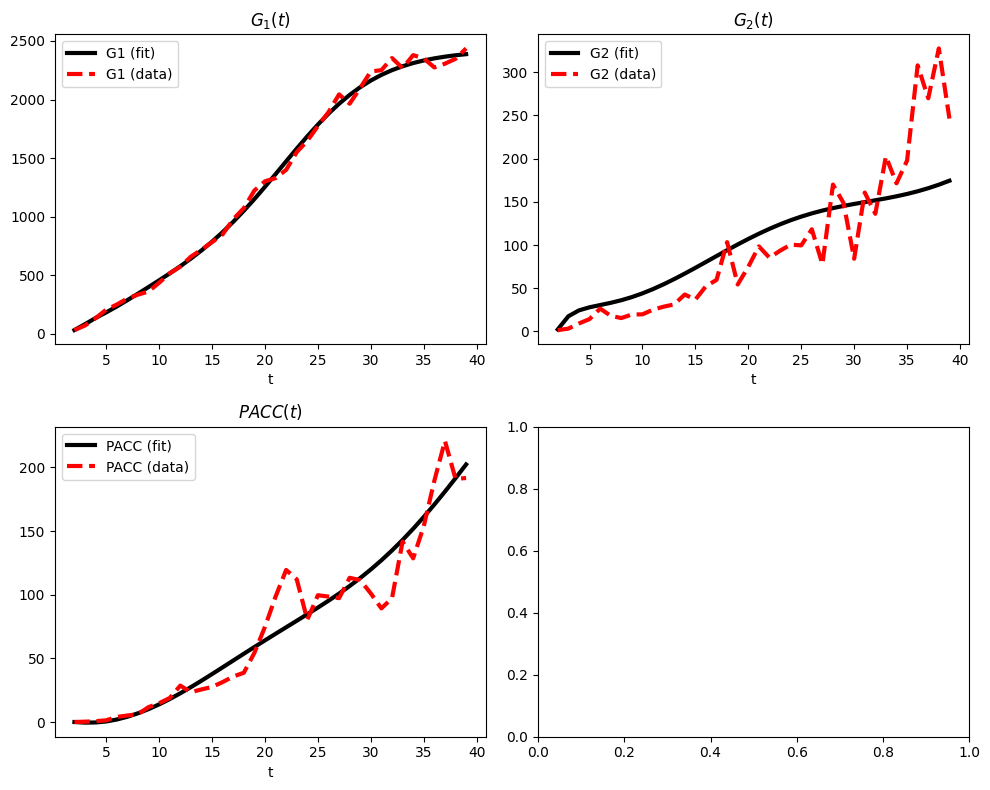

In [9]:
# PINN params
loss_param = pd.read_csv('loss_param_1f.csv')
k1 = loss_param['k1']; k2 = loss_param['k2']; k3 = loss_param['k3']; 
k1_param = k1[len(k1)-1]; k2_param = k2[len(k2)-1]; k3_param = k3[len(k3)-1]; 

print('k1='+str(k1_param))
print('k2='+str(k2_param))
print('k3='+str(k3_param))


fig, ((ax0, ax1),(ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

ax0.set_title(r'$G_1(t)$',fontsize = 12)
ax0.plot(t, file_G1_pred, 'k-', label='G1 (fit)',linewidth=3.0)
ax0.plot(t, file_G1, 'r--', label='G1 (data)',linewidth=3.0)
ax0.set_xlabel('t',fontsize = 10)
ax0.legend()

ax1.set_title(r'$G_2(t)$',fontsize = 12)
ax1.plot(t, file_G2_pred, 'k-', label='G2 (fit)',linewidth=3.0)
ax1.plot(t, file_G2, 'r--', label='G2 (data)',linewidth=3.0)
ax1.set_xlabel('t',fontsize = 10)
ax1.legend()

ax2.set_title(r'$PACC(t)$',fontsize = 12)
ax2.plot(t, file_P_pred, 'k-', label='PACC (fit)',linewidth=3.0)
ax2.plot(t, file_P, 'r--', label='PACC (data)',linewidth=3.0)
ax2.set_xlabel('t',fontsize = 10)
ax2.legend()

# ax3.set_title(r'$D(t)$',fontsize = 12)
# ax3.plot(t, file_D_pred, 'k-', label='D (fit) ',linewidth=3.0)
# ax3.plot(t, file_D, 'r--', label=r'D (data)',linewidth=3.0)
# ax3.set_xlabel('t',fontsize = 10)
# ax3.legend()

fig.tight_layout()

plt.show()




In [10]:
# no_GEM 2N
# B_2

file_G1, file_G2, file_P, file_G1_pred, file_G2_pred, file_P_pred, = drug_dose_param(pd.read_csv('csvs/B_2.csv'),t)


Epoch [200/6000] Loss: 7.29e-03 params: [0.12773909 0.42872912 0.2697777 ]
Epoch [400/6000] Loss: 2.40e-03 params: [0.06916153 0.4583141  0.22516179]
Epoch [600/6000] Loss: 1.73e-03 params: [0.06233972 0.46511385 0.16989061]
Epoch [800/6000] Loss: 1.55e-03 params: [0.06066565 0.46885943 0.12248936]
Epoch [1000/6000] Loss: 1.47e-03 params: [0.05905753 0.47078812 0.0879773 ]
Epoch [1200/6000] Loss: 1.43e-03 params: [0.05769622 0.47099203 0.06544616]
Epoch 01265: reducing learning rate of group 0 to 5.0000e-04.
Epoch [1400/6000] Loss: 1.42e-03 params: [0.05698595 0.47031885 0.05562826]
Epoch [1600/6000] Loss: 1.40e-03 params: [0.05646609 0.46946877 0.05008322]
Epoch [1800/6000] Loss: 1.39e-03 params: [0.05599387 0.46832794 0.04581252]
Epoch [2000/6000] Loss: 1.38e-03 params: [0.05556306 0.4669307  0.04262196]
Epoch [2200/6000] Loss: 1.37e-03 params: [0.05516383 0.4653199  0.04027092]
Epoch [2400/6000] Loss: 1.68e-03 params: [0.05477643 0.46354043 0.03851853]
Epoch [2600/6000] Loss: 1.35e-

k1=0.051268846
k2=0.44210282
k3=0.028192943


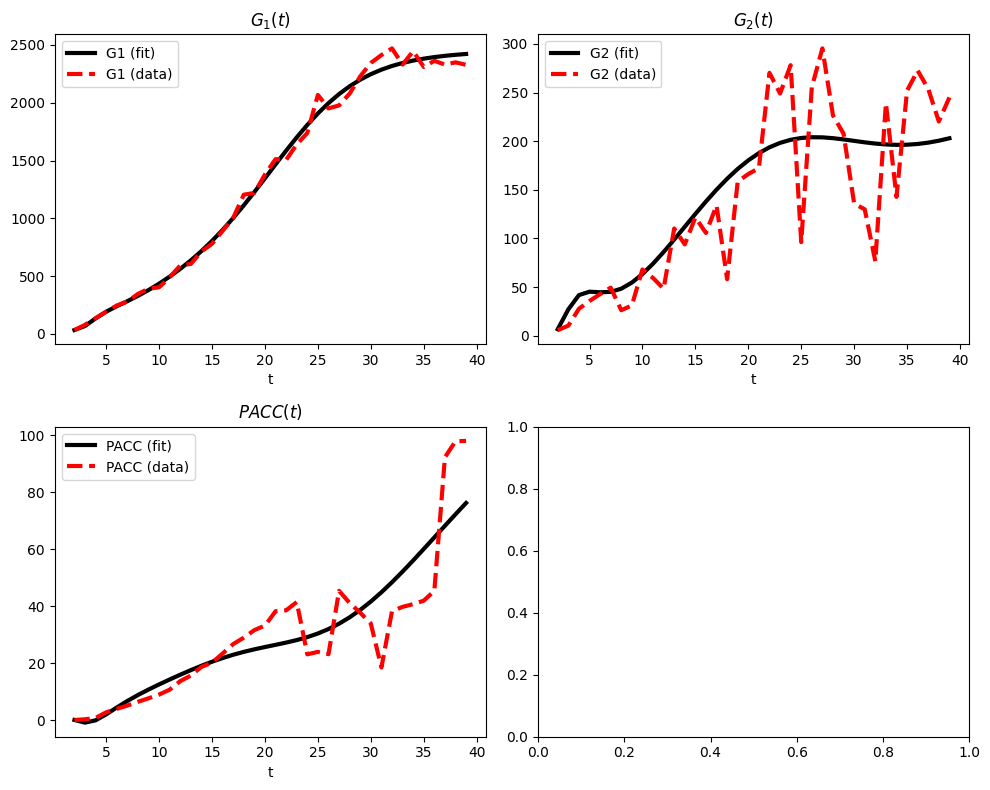

In [11]:
# PINN params
loss_param = pd.read_csv('loss_param_1f.csv')
k1 = loss_param['k1']; k2 = loss_param['k2']; k3 = loss_param['k3']; 
k1_param = k1[len(k1)-1]; k2_param = k2[len(k2)-1]; k3_param = k3[len(k3)-1]; 

print('k1='+str(k1_param))
print('k2='+str(k2_param))
print('k3='+str(k3_param))


fig, ((ax0, ax1),(ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

ax0.set_title(r'$G_1(t)$',fontsize = 12)
ax0.plot(t, file_G1_pred, 'k-', label='G1 (fit)',linewidth=3.0)
ax0.plot(t, file_G1, 'r--', label='G1 (data)',linewidth=3.0)
ax0.set_xlabel('t',fontsize = 10)
ax0.legend()

ax1.set_title(r'$G_2(t)$',fontsize = 12)
ax1.plot(t, file_G2_pred, 'k-', label='G2 (fit)',linewidth=3.0)
ax1.plot(t, file_G2, 'r--', label='G2 (data)',linewidth=3.0)
ax1.set_xlabel('t',fontsize = 10)
ax1.legend()

ax2.set_title(r'$PACC(t)$',fontsize = 12)
ax2.plot(t, file_P_pred, 'k-', label='PACC (fit)',linewidth=3.0)
ax2.plot(t, file_P, 'r--', label='PACC (data)',linewidth=3.0)
ax2.set_xlabel('t',fontsize = 10)
ax2.legend()

# ax3.set_title(r'$D(t)$',fontsize = 12)
# ax3.plot(t, file_D_pred, 'k-', label='D (fit) ',linewidth=3.0)
# ax3.plot(t, file_D, 'r--', label=r'D (data)',linewidth=3.0)
# ax3.set_xlabel('t',fontsize = 10)
# ax3.legend()

fig.tight_layout()

plt.show()




In [12]:
# no_GEM 2N
# C_2

file_G1, file_G2, file_P, file_G1_pred, file_G2_pred, file_P_pred = drug_dose_param(pd.read_csv('csvs/C_2.csv'),t)


Epoch [200/6000] Loss: 2.92e-02 params: [0.43821913 0.74353445 0.40558437]
Epoch [400/6000] Loss: 1.04e-02 params: [0.29159224 0.83725464 0.38761574]
Epoch [600/6000] Loss: 4.55e-03 params: [0.19847086 0.8772232  0.34793088]
Epoch [800/6000] Loss: 2.91e-03 params: [0.14632758 0.89081293 0.29877844]
Epoch [1000/6000] Loss: 2.47e-03 params: [0.12089698 0.892435   0.2507233 ]
Epoch [1200/6000] Loss: 2.32e-03 params: [0.10975025 0.88843817 0.21118651]
Epoch [1400/6000] Loss: 2.25e-03 params: [0.10468868 0.8814135  0.18326735]
Epoch [1600/6000] Loss: 2.15e-03 params: [0.10203168 0.87238276 0.16559148]
Epoch [1800/6000] Loss: 2.09e-03 params: [0.100209   0.86150026 0.15400013]
Epoch [2000/6000] Loss: 2.74e-03 params: [0.09861679 0.8489664  0.1459375 ]
Epoch [2200/6000] Loss: 2.00e-03 params: [0.09713622 0.83447456 0.13908198]
Epoch [2400/6000] Loss: 1.98e-03 params: [0.09548205 0.8182562  0.13293113]
Epoch [2600/6000] Loss: 1.92e-03 params: [0.09361067 0.8002053  0.1270581 ]
Epoch [2800/6000

k1=0.043130327
k2=0.39502022
k3=0.0030881555


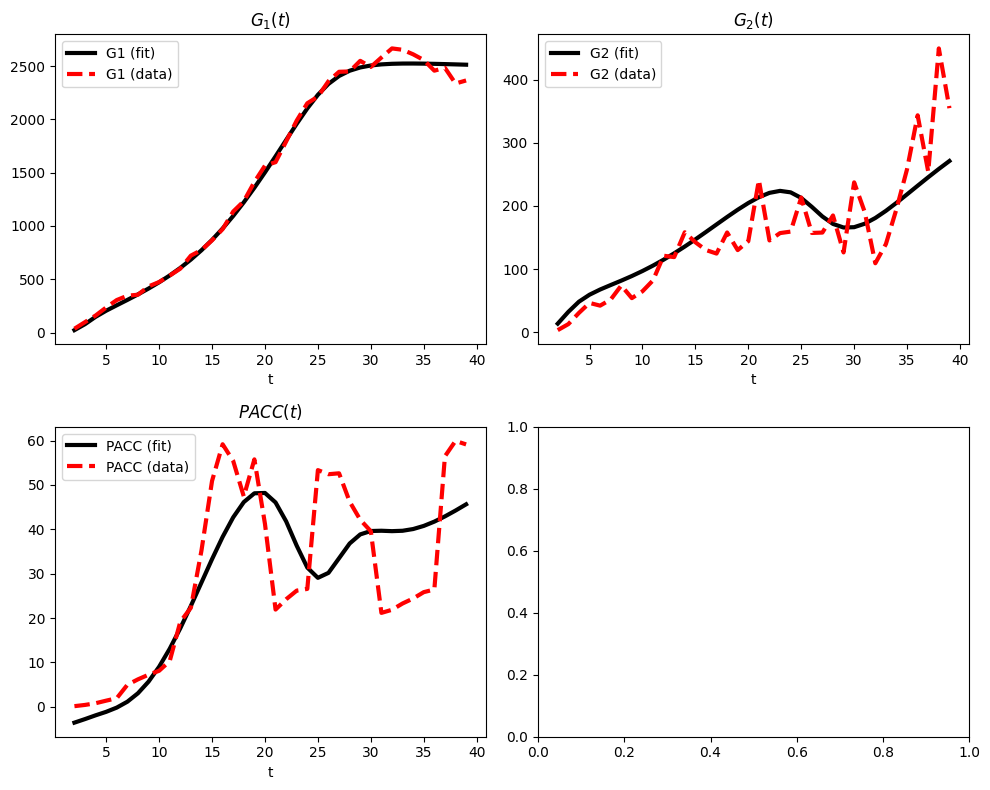

In [14]:
# PINN params
loss_param = pd.read_csv('loss_param_1f.csv')
k1 = loss_param['k1']; k2 = loss_param['k2']; k3 = loss_param['k3']; 
k1_param = k1[len(k1)-1]; k2_param = k2[len(k2)-1]; k3_param = k3[len(k3)-1]; 

print('k1='+str(k1_param))
print('k2='+str(k2_param))
print('k3='+str(k3_param))


fig, ((ax0, ax1),(ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

ax0.set_title(r'$G_1(t)$',fontsize = 12)
ax0.plot(t, file_G1_pred, 'k-', label='G1 (fit)',linewidth=3.0)
ax0.plot(t, file_G1, 'r--', label='G1 (data)',linewidth=3.0)
ax0.set_xlabel('t',fontsize = 10)
ax0.legend()

ax1.set_title(r'$G_2(t)$',fontsize = 12)
ax1.plot(t, file_G2_pred, 'k-', label='G2 (fit)',linewidth=3.0)
ax1.plot(t, file_G2, 'r--', label='G2 (data)',linewidth=3.0)
ax1.set_xlabel('t',fontsize = 10)
ax1.legend()

ax2.set_title(r'$PACC(t)$',fontsize = 12)
ax2.plot(t, file_P_pred, 'k-', label='PACC (fit)',linewidth=3.0)
ax2.plot(t, file_P, 'r--', label='PACC (data)',linewidth=3.0)
ax2.set_xlabel('t',fontsize = 10)
ax2.legend()

# ax3.set_title(r'$D(t)$',fontsize = 12)
# ax3.plot(t, file_D_pred, 'k-', label='D (fit) ',linewidth=3.0)
# ax3.plot(t, file_D, 'r--', label=r'D (data)',linewidth=3.0)
# ax3.set_xlabel('t',fontsize = 10)
# ax3.legend()

fig.tight_layout()

plt.show()




In [15]:
# no_GEM 2N
# D_2

file_G1, file_G2, file_P, file_G1_pred, file_G2_pred, file_P_pred = drug_dose_param(pd.read_csv('csvs/D_2.csv'),t)


Epoch [200/6000] Loss: 6.57e-02 params: [0.78977156 0.9999881  0.265004  ]
Epoch [400/6000] Loss: 3.36e-02 params: [0.61316156 1.1256087  0.36657098]
Epoch [600/6000] Loss: 1.73e-02 params: [0.46882558 1.2032465  0.41719237]
Epoch [800/6000] Loss: 9.15e-03 params: [0.35523027 1.2476908  0.4400004 ]
Epoch [1000/6000] Loss: 5.32e-03 params: [0.27080432 1.270256   0.44728717]
Epoch [1200/6000] Loss: 3.71e-03 params: [0.21247813 1.2793409  0.4459246 ]
Epoch [1400/6000] Loss: 3.10e-03 params: [0.17542705 1.2804153  0.43976575]
Epoch [1600/6000] Loss: 2.88e-03 params: [0.15399052 1.2770109  0.431044  ]
Epoch [1800/6000] Loss: 2.78e-03 params: [0.14265649 1.2707084  0.42079213]
Epoch [2000/6000] Loss: 2.72e-03 params: [0.13703808 1.2626832  0.409758  ]
Epoch [2200/6000] Loss: 2.66e-03 params: [0.134258  1.2528548 0.3980472]
Epoch [2400/6000] Loss: 2.61e-03 params: [0.13259962 1.2414981  0.38594463]
Epoch [2600/6000] Loss: 2.58e-03 params: [0.13128336 1.2285193  0.37351272]
Epoch [2800/6000] L

k1=0.08221915
k2=0.6826703
k3=0.15222451


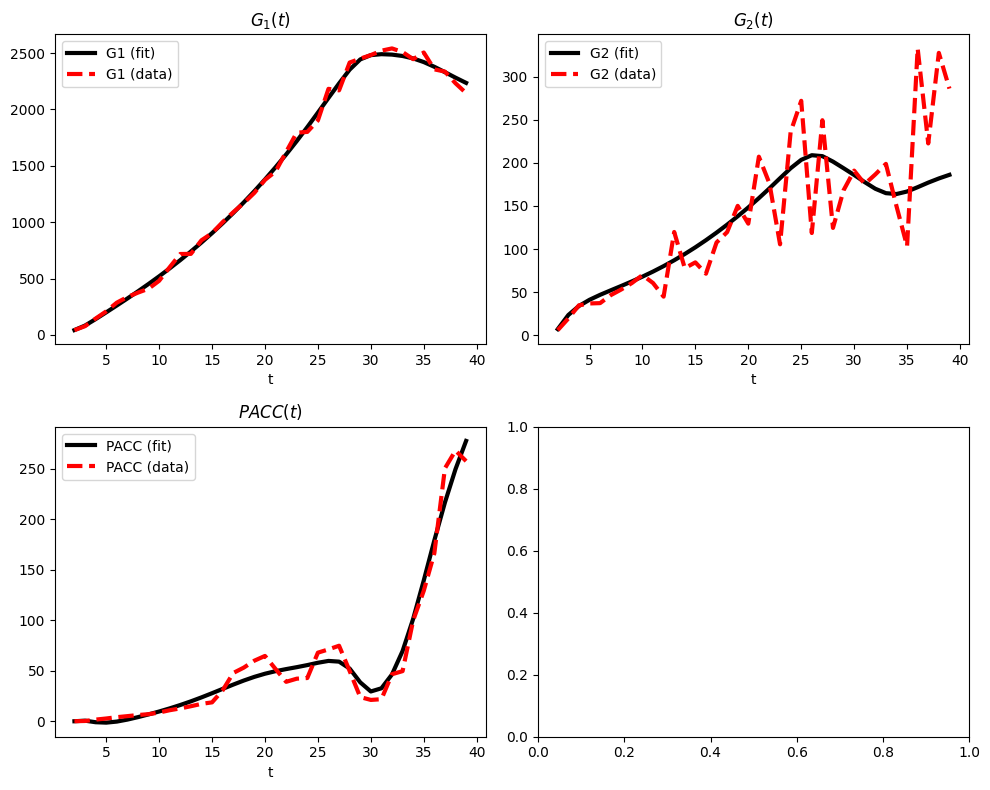

In [16]:
# PINN params
loss_param = pd.read_csv('loss_param_1f.csv')
k1 = loss_param['k1']; k2 = loss_param['k2']; k3 = loss_param['k3']; 
k1_param = k1[len(k1)-1]; k2_param = k2[len(k2)-1]; k3_param = k3[len(k3)-1]; 

print('k1='+str(k1_param))
print('k2='+str(k2_param))
print('k3='+str(k3_param))


fig, ((ax0, ax1),(ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

ax0.set_title(r'$G_1(t)$',fontsize = 12)
ax0.plot(t, file_G1_pred, 'k-', label='G1 (fit)',linewidth=3.0)
ax0.plot(t, file_G1, 'r--', label='G1 (data)',linewidth=3.0)
ax0.set_xlabel('t',fontsize = 10)
ax0.legend()

ax1.set_title(r'$G_2(t)$',fontsize = 12)
ax1.plot(t, file_G2_pred, 'k-', label='G2 (fit)',linewidth=3.0)
ax1.plot(t, file_G2, 'r--', label='G2 (data)',linewidth=3.0)
ax1.set_xlabel('t',fontsize = 10)
ax1.legend()

ax2.set_title(r'$PACC(t)$',fontsize = 12)
ax2.plot(t, file_P_pred, 'k-', label='PACC (fit)',linewidth=3.0)
ax2.plot(t, file_P, 'r--', label='PACC (data)',linewidth=3.0)
ax2.set_xlabel('t',fontsize = 10)
ax2.legend()

# ax3.set_title(r'$D(t)$',fontsize = 12)
# ax3.plot(t, file_D_pred, 'k-', label='D (fit) ',linewidth=3.0)
# ax3.plot(t, file_D, 'r--', label=r'D (data)',linewidth=3.0)
# ax3.set_xlabel('t',fontsize = 10)
# ax3.legend()

fig.tight_layout()

plt.show()




### 4N

In [17]:
# no_GEM 4N
# E_2

file_G1, file_G2, file_P, file_G1_pred, file_G2_pred, file_P_pred = drug_dose_param(pd.read_csv('csvs/E_2.csv'),t)


Epoch [200/6000] Loss: 4.77e-02 params: [0.64346594 1.1837459  0.23592287]
Epoch [400/6000] Loss: 2.26e-02 params: [0.47622856 1.3002899  0.337371  ]
Epoch [600/6000] Loss: 1.06e-02 params: [0.34285995 1.3700205  0.38926318]
Epoch [800/6000] Loss: 4.82e-03 params: [0.24051498 1.4093199  0.41330546]
Epoch [1000/6000] Loss: 2.24e-03 params: [0.16638449 1.430266   0.42216644]
Epoch [1200/6000] Loss: 1.22e-03 params: [0.11649097 1.4409279  0.42312384]
Epoch [1400/6000] Loss: 8.70e-04 params: [0.08560093 1.4463834  0.42019868]
Epoch [1600/6000] Loss: 3.65e-03 params: [0.06837552 1.4495178  0.41537458]
Epoch 01631: reducing learning rate of group 0 to 5.0000e-04.
Epoch [1800/6000] Loss: 7.18e-04 params: [0.06251671 1.4507186  0.4119524 ]
Epoch [2000/6000] Loss: 6.94e-04 params: [0.05907977 1.4516943  0.40856186]
Epoch [2200/6000] Loss: 6.77e-04 params: [0.05675609 1.4525985  0.40474102]
Epoch [2400/6000] Loss: 6.63e-04 params: [0.05528924 1.4534632  0.40048328]
Epoch [2600/6000] Loss: 6.51e-

k1=0.053043358
k2=1.4621371
k3=0.32943082


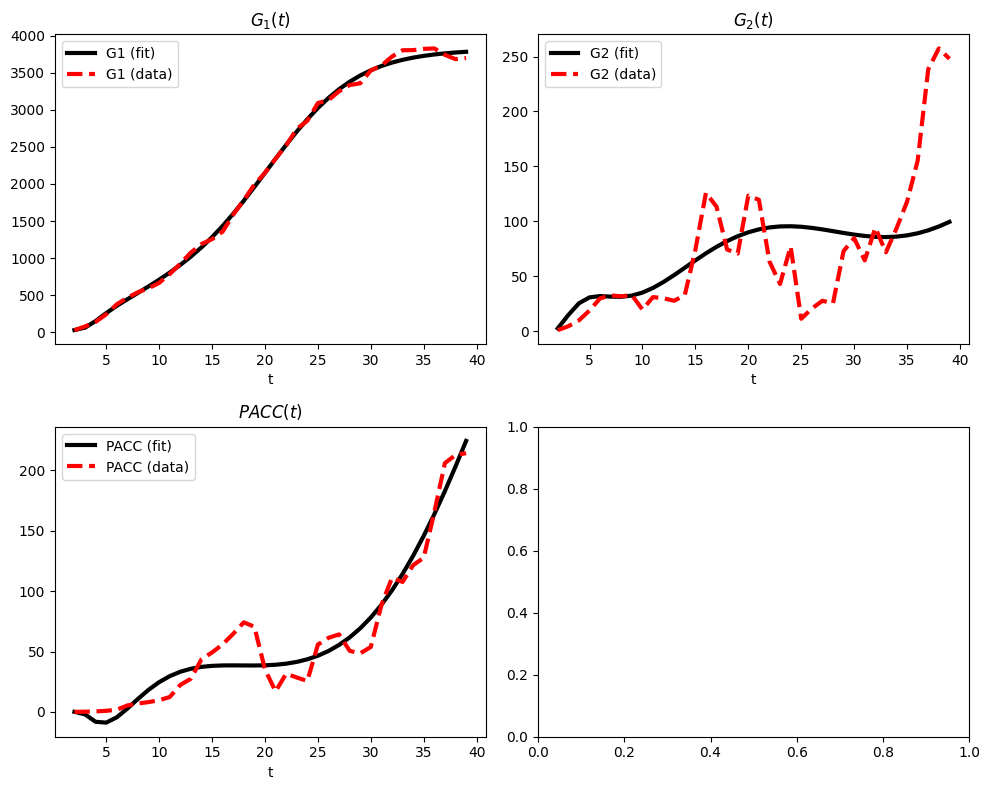

In [18]:
# PINN params
loss_param = pd.read_csv('loss_param_1f.csv')
k1 = loss_param['k1']; k2 = loss_param['k2']; k3 = loss_param['k3']; 
k1_param = k1[len(k1)-1]; k2_param = k2[len(k2)-1]; k3_param = k3[len(k3)-1]; 

print('k1='+str(k1_param))
print('k2='+str(k2_param))
print('k3='+str(k3_param))


fig, ((ax0, ax1),(ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

ax0.set_title(r'$G_1(t)$',fontsize = 12)
ax0.plot(t, file_G1_pred, 'k-', label='G1 (fit)',linewidth=3.0)
ax0.plot(t, file_G1, 'r--', label='G1 (data)',linewidth=3.0)
ax0.set_xlabel('t',fontsize = 10)
ax0.legend()

ax1.set_title(r'$G_2(t)$',fontsize = 12)
ax1.plot(t, file_G2_pred, 'k-', label='G2 (fit)',linewidth=3.0)
ax1.plot(t, file_G2, 'r--', label='G2 (data)',linewidth=3.0)
ax1.set_xlabel('t',fontsize = 10)
ax1.legend()

ax2.set_title(r'$PACC(t)$',fontsize = 12)
ax2.plot(t, file_P_pred, 'k-', label='PACC (fit)',linewidth=3.0)
ax2.plot(t, file_P, 'r--', label='PACC (data)',linewidth=3.0)
ax2.set_xlabel('t',fontsize = 10)
ax2.legend()

# ax3.set_title(r'$D(t)$',fontsize = 12)
# ax3.plot(t, file_D_pred, 'k-', label='D (fit) ',linewidth=3.0)
# ax3.plot(t, file_D, 'r--', label=r'D (data)',linewidth=3.0)
# ax3.set_xlabel('t',fontsize = 10)
# ax3.legend()

fig.tight_layout()

plt.show()




In [19]:
# no_GEM 4N
# F_2

file_G1, file_G2, file_P, file_G1_pred, file_G2_pred, file_P_pred = drug_dose_param(pd.read_csv('csvs/F_2.csv'),t)


Epoch [200/6000] Loss: 7.33e-03 params: [0.15457685 0.7696334  0.56859773]
Epoch [400/6000] Loss: 3.02e-03 params: [0.08014547 0.80349576 0.5106578 ]
Epoch [600/6000] Loss: 2.20e-03 params: [0.06428099 0.8145188  0.45962134]
Epoch [800/6000] Loss: 1.85e-03 params: [0.06353553 0.82124805 0.40653494]
Epoch [1000/6000] Loss: 1.68e-03 params: [0.06426045 0.82658845 0.35279068]
Epoch [1200/6000] Loss: 1.57e-03 params: [0.06446032 0.83055186 0.30212888]
Epoch [1400/6000] Loss: 1.50e-03 params: [0.06407064 0.83286995 0.25743413]
Epoch [1600/6000] Loss: 1.45e-03 params: [0.06329984 0.83341056 0.22013327]
Epoch [1800/6000] Loss: 1.42e-03 params: [0.06233981 0.83221805 0.1904071 ]
Epoch [2000/6000] Loss: 1.39e-03 params: [0.06146076 0.8293585  0.16750655]
Epoch [2200/6000] Loss: 1.37e-03 params: [0.06058876 0.82495177 0.15029347]
Epoch [2400/6000] Loss: 1.36e-03 params: [0.05977912 0.8192915  0.13771196]
Epoch [2600/6000] Loss: 1.35e-03 params: [0.05901314 0.8122623  0.1282552 ]
Epoch [2800/6000

k1=0.04907073
k2=0.69042283
k3=0.07627169


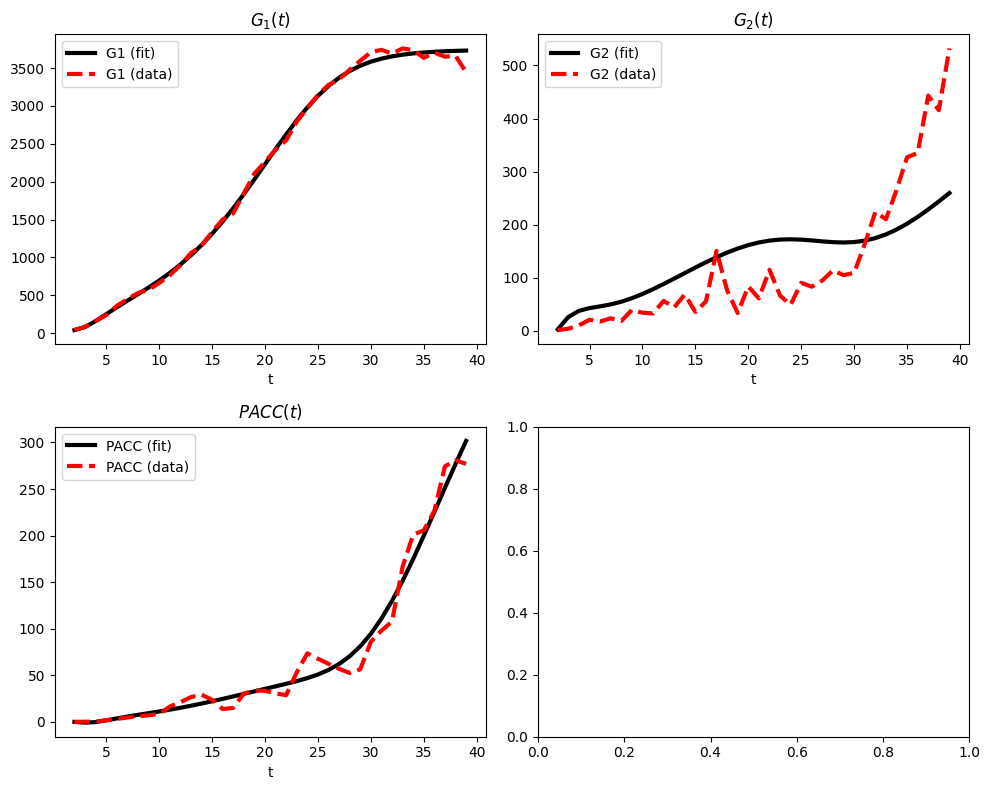

In [20]:
# PINN params
loss_param = pd.read_csv('loss_param_1f.csv')
k1 = loss_param['k1']; k2 = loss_param['k2']; k3 = loss_param['k3']; 
k1_param = k1[len(k1)-1]; k2_param = k2[len(k2)-1]; k3_param = k3[len(k3)-1]; 

print('k1='+str(k1_param))
print('k2='+str(k2_param))
print('k3='+str(k3_param))


fig, ((ax0, ax1),(ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

ax0.set_title(r'$G_1(t)$',fontsize = 12)
ax0.plot(t, file_G1_pred, 'k-', label='G1 (fit)',linewidth=3.0)
ax0.plot(t, file_G1, 'r--', label='G1 (data)',linewidth=3.0)
ax0.set_xlabel('t',fontsize = 10)
ax0.legend()

ax1.set_title(r'$G_2(t)$',fontsize = 12)
ax1.plot(t, file_G2_pred, 'k-', label='G2 (fit)',linewidth=3.0)
ax1.plot(t, file_G2, 'r--', label='G2 (data)',linewidth=3.0)
ax1.set_xlabel('t',fontsize = 10)
ax1.legend()

ax2.set_title(r'$PACC(t)$',fontsize = 12)
ax2.plot(t, file_P_pred, 'k-', label='PACC (fit)',linewidth=3.0)
ax2.plot(t, file_P, 'r--', label='PACC (data)',linewidth=3.0)
ax2.set_xlabel('t',fontsize = 10)
ax2.legend()

# ax3.set_title(r'$D(t)$',fontsize = 12)
# ax3.plot(t, file_D_pred, 'k-', label='D (fit) ',linewidth=3.0)
# ax3.plot(t, file_D, 'r--', label=r'D (data)',linewidth=3.0)
# ax3.set_xlabel('t',fontsize = 10)
# ax3.legend()

fig.tight_layout()

plt.show()




In [21]:
# no_GEM 4N
# G_2

file_G1, file_G2, file_P, file_G1_pred, file_G2_pred, file_P_pred = drug_dose_param(pd.read_csv('csvs/G_2.csv'),t)


Epoch [200/6000] Loss: 5.62e-02 params: [0.37266353 0.36082473 0.8752488 ]
Epoch [400/6000] Loss: 1.92e-02 params: [0.21706757 0.48285705 0.7305522 ]
Epoch [600/6000] Loss: 5.65e-03 params: [0.12112096 0.5359479  0.6405528 ]
Epoch [800/6000] Loss: 2.53e-03 params: [0.06685913 0.5577115  0.58349717]
Epoch [1000/6000] Loss: 1.74e-03 params: [0.03996944 0.56741935 0.54044896]
Epoch [1200/6000] Loss: 1.52e-03 params: [0.02886748 0.5729934  0.50160533]
Epoch 01267: reducing learning rate of group 0 to 5.0000e-04.
Epoch [1400/6000] Loss: 1.46e-03 params: [0.02610102 0.5759824  0.47502318]
Epoch [1600/6000] Loss: 1.39e-03 params: [0.02529414 0.5782423  0.45312023]
Epoch [1800/6000] Loss: 1.32e-03 params: [0.02514927 0.58063114 0.42902994]
Epoch [2000/6000] Loss: 1.26e-03 params: [0.02540798 0.5831955  0.40269035]
Epoch [2200/6000] Loss: 1.20e-03 params: [0.02587665 0.58596534 0.37418267]
Epoch [2400/6000] Loss: 1.15e-03 params: [0.0264145  0.58895034 0.34374925]
Epoch [2600/6000] Loss: 1.11e-

k1=0.026473138
k2=0.63978285
k3=0.03376614


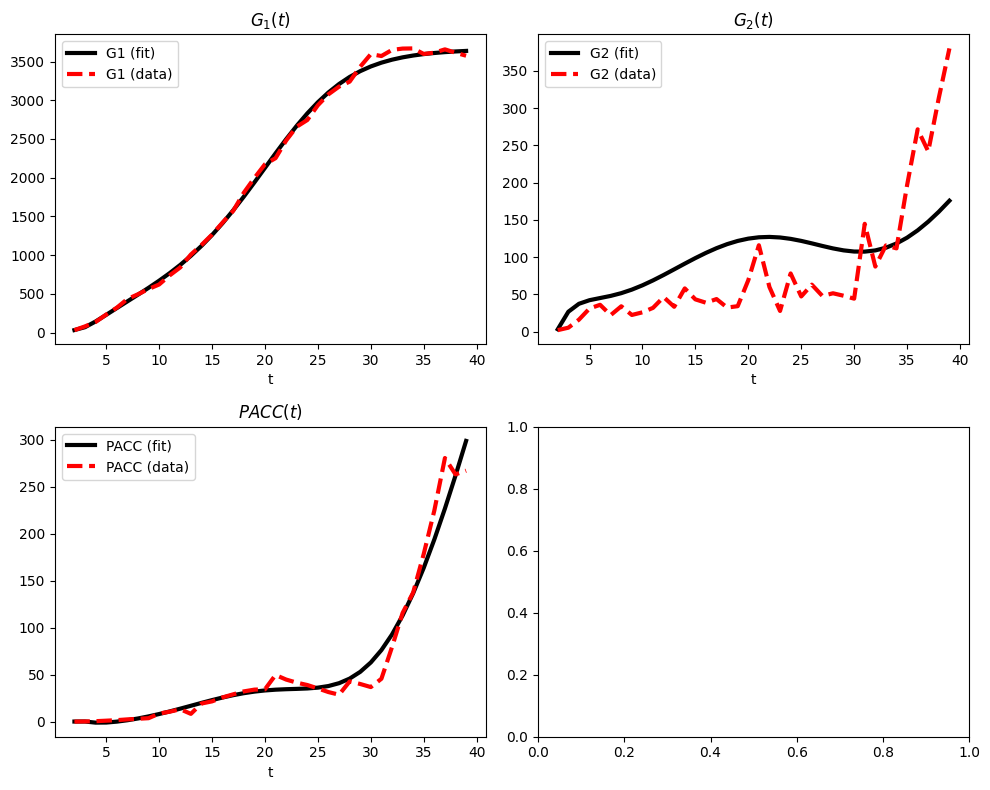

In [22]:
# PINN params
loss_param = pd.read_csv('loss_param_1f.csv')
k1 = loss_param['k1']; k2 = loss_param['k2']; k3 = loss_param['k3']; 
k1_param = k1[len(k1)-1]; k2_param = k2[len(k2)-1]; k3_param = k3[len(k3)-1]; 

print('k1='+str(k1_param))
print('k2='+str(k2_param))
print('k3='+str(k3_param))


fig, ((ax0, ax1),(ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

ax0.set_title(r'$G_1(t)$',fontsize = 12)
ax0.plot(t, file_G1_pred, 'k-', label='G1 (fit)',linewidth=3.0)
ax0.plot(t, file_G1, 'r--', label='G1 (data)',linewidth=3.0)
ax0.set_xlabel('t',fontsize = 10)
ax0.legend()

ax1.set_title(r'$G_2(t)$',fontsize = 12)
ax1.plot(t, file_G2_pred, 'k-', label='G2 (fit)',linewidth=3.0)
ax1.plot(t, file_G2, 'r--', label='G2 (data)',linewidth=3.0)
ax1.set_xlabel('t',fontsize = 10)
ax1.legend()

ax2.set_title(r'$PACC(t)$',fontsize = 12)
ax2.plot(t, file_P_pred, 'k-', label='PACC (fit)',linewidth=3.0)
ax2.plot(t, file_P, 'r--', label='PACC (data)',linewidth=3.0)
ax2.set_xlabel('t',fontsize = 10)
ax2.legend()

# ax3.set_title(r'$D(t)$',fontsize = 12)
# ax3.plot(t, file_D_pred, 'k-', label='D (fit) ',linewidth=3.0)
# ax3.plot(t, file_D, 'r--', label=r'D (data)',linewidth=3.0)
# ax3.set_xlabel('t',fontsize = 10)
# ax3.legend()

fig.tight_layout()

plt.show()




In [23]:
# no_GEM 4N
# H_2

file_G1, file_G2, file_P, file_G1_pred, file_G2_pred, file_P_pred = drug_dose_param(pd.read_csv('csvs/H_2.csv'),t)


Epoch [200/6000] Loss: 4.18e-02 params: [0.33446893 0.33800077 0.43345928]
Epoch [400/6000] Loss: 1.24e-02 params: [0.18807386 0.44197997 0.4468951 ]
Epoch [600/6000] Loss: 4.35e-03 params: [0.09902032 0.48404676 0.42210382]
Epoch [800/6000] Loss: 2.27e-03 params: [0.05087357 0.5004462  0.39221916]
Epoch [1000/6000] Loss: 1.78e-03 params: [0.02888011 0.50781184 0.36218792]
Epoch 01167: reducing learning rate of group 0 to 5.0000e-04.
Epoch [1200/6000] Loss: 1.61e-03 params: [0.02115071 0.5121066  0.3338078 ]
Epoch [1400/6000] Loss: 1.50e-03 params: [0.01946183 0.51423556 0.31698242]
Epoch [1600/6000] Loss: 1.41e-03 params: [0.01865515 0.5164755  0.2984113 ]
Epoch [1800/6000] Loss: 1.32e-03 params: [0.01839093 0.51889306 0.27808785]
Epoch [2000/6000] Loss: 1.24e-03 params: [0.01840672 0.52153915 0.25608146]
Epoch [2200/6000] Loss: 1.18e-03 params: [0.01853012 0.52444184 0.23255336]
Epoch [2400/6000] Loss: 1.13e-03 params: [0.01866172 0.5276221  0.20775795]
Epoch 02596: reducing learning

k1=0.019444399
k2=0.5978973
k3=2.7287226e-05


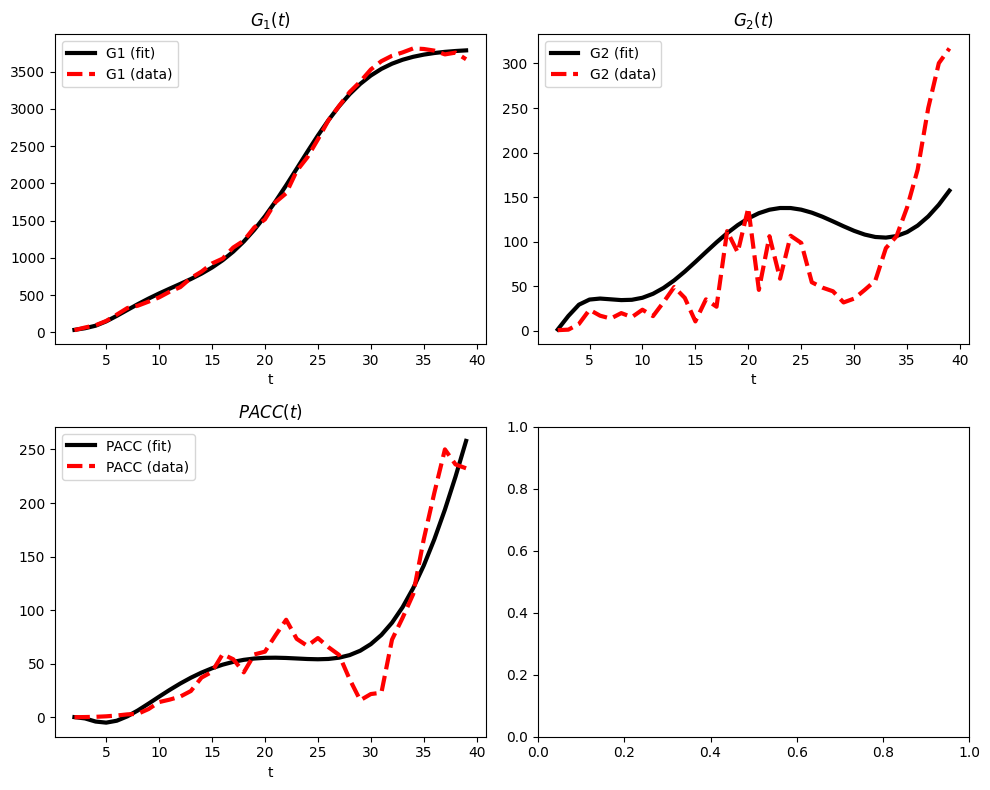

In [24]:
# PINN params
loss_param = pd.read_csv('loss_param_1f.csv')
k1 = loss_param['k1']; k2 = loss_param['k2']; k3 = loss_param['k3']; 
k1_param = k1[len(k1)-1]; k2_param = k2[len(k2)-1]; k3_param = k3[len(k3)-1]; 

print('k1='+str(k1_param))
print('k2='+str(k2_param))
print('k3='+str(k3_param))


fig, ((ax0, ax1),(ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

ax0.set_title(r'$G_1(t)$',fontsize = 12)
ax0.plot(t, file_G1_pred, 'k-', label='G1 (fit)',linewidth=3.0)
ax0.plot(t, file_G1, 'r--', label='G1 (data)',linewidth=3.0)
ax0.set_xlabel('t',fontsize = 10)
ax0.legend()

ax1.set_title(r'$G_2(t)$',fontsize = 12)
ax1.plot(t, file_G2_pred, 'k-', label='G2 (fit)',linewidth=3.0)
ax1.plot(t, file_G2, 'r--', label='G2 (data)',linewidth=3.0)
ax1.set_xlabel('t',fontsize = 10)
ax1.legend()

ax2.set_title(r'$PACC(t)$',fontsize = 12)
ax2.plot(t, file_P_pred, 'k-', label='PACC (fit)',linewidth=3.0)
ax2.plot(t, file_P, 'r--', label='PACC (data)',linewidth=3.0)
ax2.set_xlabel('t',fontsize = 10)
ax2.legend()

# ax3.set_title(r'$D(t)$',fontsize = 12)
# ax3.plot(t, file_D_pred, 'k-', label='D (fit) ',linewidth=3.0)
# ax3.plot(t, file_D, 'r--', label=r'D (data)',linewidth=3.0)
# ax3.set_xlabel('t',fontsize = 10)
# ax3.legend()

fig.tight_layout()

plt.show()




In [26]:
import nbformat
import re
import numpy as np

# Path to the current notebook
notebook_path = "no_GEM_noD.ipynb"  # Replace with the actual filename of your notebook

# Lists to store the extracted values
k1_values, k2_values, k3_values = [], [], []

# Load the notebook
with open(notebook_path, "r", encoding="utf-8") as f:
    notebook = nbformat.read(f, as_version=4)

# Iterate over each cell in the notebook
for cell in notebook.cells:
    # Check if the cell contains output
    if cell.cell_type == "code" and "outputs" in cell:
        for output in cell.outputs:
            # Ensure the output is text type and check for pattern
            if output.output_type == "stream" and "text" in output:
                output_text = output["text"]

                # Use regex to extract fg, fm, and fp values
                k1_match = re.search(r"k1=([\d.eE+-]+)", output_text)
                k2_match = re.search(r"k2=([\d.eE+-]+)", output_text)
                k3_match = re.search(r"k3=([\d.eE+-]+)", output_text)

                # Append values if all three are found
                if k1_match:
                    k1_values.append(float(k1_match.group(1)))
                if k2_match:
                    k2_values.append(float(k2_match.group(1)))
                if k3_match:
                    k3_values.append(float(k3_match.group(1)))

# Convert lists to separate matrices
k1_matrix = np.array(k1_values).reshape(-1, 1)
k2_matrix = np.array(k2_values).reshape(-1, 1)
k3_matrix = np.array(k3_values).reshape(-1, 1)

# Display the matrices
print("k1 Matrix:")
print(k1_matrix)
print("\nk2 Matrix:")
print(k2_matrix)
print("\nk3 Matrix:")
print(k3_matrix)


k1 Matrix:
[[0.08674041]
 [0.05126885]
 [0.04313033]
 [0.08221915]
 [0.05304336]
 [0.04907073]
 [0.02647314]
 [0.0194444 ]]

k2 Matrix:
[[0.86903095]
 [0.44210282]
 [0.39502022]
 [0.6826703 ]
 [1.4621371 ]
 [0.69042283]
 [0.63978285]
 [0.5978973 ]]

k3 Matrix:
[[1.8202210e-01]
 [2.8192943e-02]
 [3.0881555e-03]
 [1.5222451e-01]
 [3.2943082e-01]
 [7.6271690e-02]
 [3.3766140e-02]
 [2.7287226e-05]]


In [40]:
k1_matrix_2d = k1_matrix.reshape(2,4)
k1_matrix_2d_T = k1_matrix_2d.T

k2_matrix_2d = k2_matrix.reshape(2,4)
k2_matrix_2d_T = k2_matrix_2d.T

k3_matrix_2d = k3_matrix.reshape(2,4)
k3_matrix_2d_T = k3_matrix_2d.T

In [41]:
print(k1_matrix_2d)

[[0.08674041 0.05126885 0.04313033 0.08221915]
 [0.05304336 0.04907073 0.02647314 0.0194444 ]]


In [42]:
print(k2_matrix_2d)

[[0.86903095 0.44210282 0.39502022 0.6826703 ]
 [1.4621371  0.69042283 0.63978285 0.5978973 ]]


In [43]:
print(k3_matrix_2d)

[[1.8202210e-01 2.8192943e-02 3.0881555e-03 1.5222451e-01]
 [3.2943082e-01 7.6271690e-02 3.3766140e-02 2.7287226e-05]]


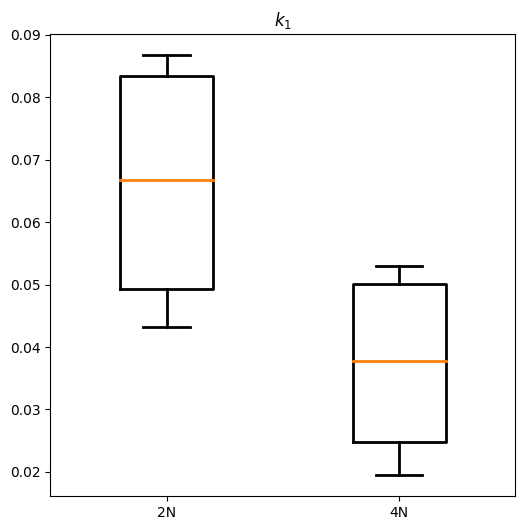

In [44]:
# creating box plots

# Create a boxplot for each array on the same plot
plt.figure(figsize=(6, 6))
boxprops = dict(linewidth=2)  # Bold box lines
whiskerprops = dict(linewidth=2)  # Bold whisker lines
capprops = dict(linewidth=2)  # Bold cap lines
medianprops = dict(linewidth=2)  # Bold median line

plt.boxplot([k1_matrix_2d[0,:], k1_matrix_2d[1,:]], labels=['2N', '4N'], widths=0.4,
            boxprops=boxprops, whiskerprops=whiskerprops,
            capprops=capprops, medianprops=medianprops)
# plt.ylabel("Values")
plt.title(r"$k_1$")
plt.show()

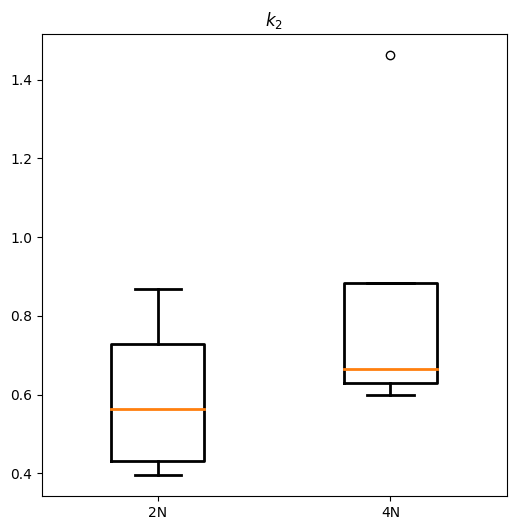

In [45]:
# creating box plots

# Create a boxplot for each array on the same plot
plt.figure(figsize=(6, 6))
boxprops = dict(linewidth=2)  # Bold box lines
whiskerprops = dict(linewidth=2)  # Bold whisker lines
capprops = dict(linewidth=2)  # Bold cap lines
medianprops = dict(linewidth=2)  # Bold median line

plt.boxplot([k2_matrix_2d[0,:], k2_matrix_2d[1,:]], labels=['2N', '4N'], widths=0.4,
            boxprops=boxprops, whiskerprops=whiskerprops,
            capprops=capprops, medianprops=medianprops)
# plt.ylabel("Values")
plt.title(r"$k_2$")
plt.show()

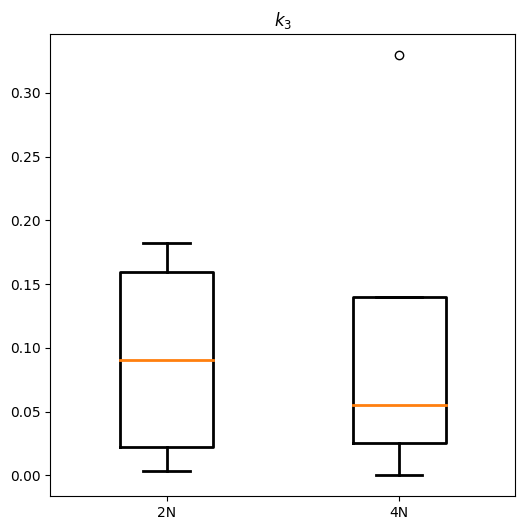

In [55]:
# creating box plots

# Create a boxplot for each array on the same plot
plt.figure(figsize=(6, 6))
boxprops = dict(linewidth=2)  # Bold box lines
whiskerprops = dict(linewidth=2)  # Bold whisker lines
capprops = dict(linewidth=2)  # Bold cap lines
medianprops = dict(linewidth=2)  # Bold median line

plt.boxplot([k3_matrix_2d[0,:], k3_matrix_2d[1,:]], labels=['2N', '4N'], widths=0.4,
            boxprops=boxprops, whiskerprops=whiskerprops,
            capprops=capprops, medianprops=medianprops)
# plt.ylabel("Values")
plt.title(r"$k_3$")
plt.show()

In [56]:
# mean k1 2N
k1_2N_median = np.median(k1_matrix_2d[0,:])

# mean k2 2N
k2_2N_median = np.median(k2_matrix_2d[0,:])

# mean k3 2N
k3_2N_median = np.median(k3_matrix_2d[0,:])



In [57]:
# mean k1 4N
k1_4N_median = np.median(k1_matrix_2d[1,:])

# mean k2 4N
k2_4N_median = np.median(k2_matrix_2d[1,:])

# mean k3 4N
k3_4N_median = np.median(k3_matrix_2d[1,:])



In [58]:
kn_param_2N = np.array([k1_2N_median, k2_2N_median, k3_2N_median])

print(kn_param_2N)

[0.066744   0.56238656 0.09020873]


In [59]:
kn_param_4N = np.array([k1_4N_median, k2_4N_median, k3_4N_median])

print(kn_param_4N)

[0.03777193 0.66510284 0.05501892]


In [30]:
# # k1 2N
# k1_2N_UNTX  = np.array([0.06274018,0.07811624,0.051135186,0.06810814])

# # k1 4N
# k1_4N_UNTX  = np.array([0.03918094,0.06460599,0.05589938,0.03183698])

# # k2 2N
# k2_2N_UNTX  = np.array([0.68131554,0.6804692,0.48824948,0.62479794])

# # k2 4N
# k2_4N_UNTX  = np.array([1.2085216,0.93104225,1.4374719,0.85302514])

# # k3 2N
# k3_2N_UNTX  = np.array([0.057338193,0.04793637,1.3264705e-05,0.06354231])

# # k3 4N
# k3_4N_UNTX  = np.array([2.4809733e-06,0.11252155,0.050692756,2.699121e-07])

# # kd 2N
# kd_2N_UNTX  = np.array([0.012247945,0.016710697,0.012132769,0.014959407])

# # kd 4N
# kd_4N_UNTX  = np.array([0.0071431114,0.008868034,0.00938431,0.0034892266])

# # kd2 2N
# kd2_2N_UNTX  = np.array([0.0060835117,0.00835024,0.006038802,0.0072695985])

# # kd2 4N
# kd2_4N_UNTX  = np.array([0.0035135702,0.004382123,0.004546016,0.0029570158])

In [46]:
# # creating box plots

# # Create a boxplot for each array on the same plot
# plt.figure(figsize=(6, 6))
# boxprops = dict(linewidth=2)  # Bold box lines
# whiskerprops = dict(linewidth=2)  # Bold whisker lines
# capprops = dict(linewidth=2)  # Bold cap lines
# medianprops = dict(linewidth=2)  # Bold median line

# plt.boxplot([k1_2N_UNTX, k1_4N_UNTX], labels=['2N', '4N'], widths=0.4,
#             boxprops=boxprops, whiskerprops=whiskerprops,
#             capprops=capprops, medianprops=medianprops)
# # plt.ylabel("Values")
# plt.title(r"$k_1$ no_GEM")
# plt.show()

In [47]:
# # creating box plots

# # Create a boxplot for each array on the same plot
# plt.figure(figsize=(6, 6))
# boxprops = dict(linewidth=2)  # Bold box lines
# whiskerprops = dict(linewidth=2)  # Bold whisker lines
# capprops = dict(linewidth=2)  # Bold cap lines
# medianprops = dict(linewidth=2)  # Bold median line

# plt.boxplot([k2_2N_UNTX, k2_4N_UNTX], labels=['2N', '4N'], widths=0.4,
#             boxprops=boxprops, whiskerprops=whiskerprops,
#             capprops=capprops, medianprops=medianprops)
# # plt.ylabel("Values")
# plt.title(r"$k_2$ no_GEM")
# plt.show()

In [48]:
# # creating box plots

# # Create a boxplot for each array on the same plot
# plt.figure(figsize=(6, 6))
# boxprops = dict(linewidth=2)  # Bold box lines
# whiskerprops = dict(linewidth=2)  # Bold whisker lines
# capprops = dict(linewidth=2)  # Bold cap lines
# medianprops = dict(linewidth=2)  # Bold median line

# plt.boxplot([k3_2N_UNTX, k3_4N_UNTX], labels=['2N', '4N'], widths=0.4,
#             boxprops=boxprops, whiskerprops=whiskerprops,
#             capprops=capprops, medianprops=medianprops)
# # plt.ylabel("Values")
# plt.title(r"$k_3$ no_GEM")
# plt.show()

In [50]:
# # creating box plots

# # Create a boxplot for each array on the same plot
# plt.figure(figsize=(6, 6))
# boxprops = dict(linewidth=2)  # Bold box lines
# whiskerprops = dict(linewidth=2)  # Bold whisker lines
# capprops = dict(linewidth=2)  # Bold cap lines
# medianprops = dict(linewidth=2)  # Bold median line

# plt.boxplot([kd_2N_UNTX, kd_4N_UNTX], labels=['2N', '4N'], widths=0.4,
#             boxprops=boxprops, whiskerprops=whiskerprops,
#             capprops=capprops, medianprops=medianprops)
# # plt.ylabel("Values")
# plt.title(r"$k_d$ no_GEM")
# plt.show()

In [49]:
# # creating box plots

# # Create a boxplot for each array on the same plot
# plt.figure(figsize=(6, 6))
# boxprops = dict(linewidth=2)  # Bold box lines
# whiskerprops = dict(linewidth=2)  # Bold whisker lines
# capprops = dict(linewidth=2)  # Bold cap lines
# medianprops = dict(linewidth=2)  # Bold median line

# plt.boxplot([kd2_2N_UNTX, kd2_4N_UNTX], labels=['2N', '4N'], widths=0.4,
#             boxprops=boxprops, whiskerprops=whiskerprops,
#             capprops=capprops, medianprops=medianprops)
# # plt.ylabel("Values")
# plt.title(r"$k_{d2}$ no_GEM")
# plt.show()

In [51]:
# # mean k1 2N
# k1_2N_median = np.median(k1_2N_UNTX)

# # mean k2 2N
# k2_2N_median = np.median(k2_2N_UNTX)

# # mean k3 2N
# k3_2N_median = np.median(k3_2N_UNTX)

# # mean kd 2N
# kd_2N_median = np.median(kd_2N_UNTX)

# # mean kd2 2N
# kd2_2N_median = np.median(kd2_2N_UNTX)

In [52]:
# # mean k1 4N
# k1_4N_median = np.median(k1_4N_UNTX)

# # mean k2 4N
# k2_4N_median = np.median(k2_4N_UNTX)

# # mean k3 4N
# k3_4N_median = np.median(k3_4N_UNTX)

# # mean kd 4N
# kd_4N_median = np.median(kd_4N_UNTX)

# # mean kd2 4N
# kd2_4N_median = np.median(kd2_4N_UNTX)

In [53]:
# kn_param_2N = np.array([k1_2N_median, k2_2N_median, k3_2N_median, kd_2N_median, kd2_2N_median])

# print(kn_param_2N)

In [54]:
# kn_param_4N = np.array([k1_4N_median, k2_4N_median, k3_4N_median, kd_4N_median, kd2_4N_median])

# print(kn_param_4N)